# Empirical Assignment (Q1)
## Economics 35310: Topics in Trade & Growth
### Author: Levi Crews

In this notebook I simulate an economy of 100,000 firms using the model from TKMD (2018). Firms are indexed from 1 to 100,000. Each set of eligible suppliers (max cardinality of 300) is drawn randomly from the set of firms whose indices precede that of the buyer. Each firm $j$ is characterized by
+ its set of eligible suppliers that satisfies the ordering ($Z_j$)
+ its core productivity level ($\phi_j$)
+ its vector of firm-pair-specific cost shifters ($\alpha_{kj}$)
+ its foreign input cost shifter ($\alpha_{Fj}$)
+ its foreign demand shifter ($\beta_{jF}$)
+ its vector of fixed cost draws for all eligible suppliers ($f_{kj}$)
+ its fixed costs of importing and exporting ($f_{Fj}$, $f_{jF}$)

I normalize firms' labor productivity shifters, $\alpha_{Lj} = 1$, and firms' domestic final demand shifters, $\beta_{jH} = 1$. I parameterize firm characteristics in the following way:
+ $\alpha_{kj} = X_k \times Y_{kj}$ with $X_k \sim $ Beta(0.1, 0.9) and $Y_{kj} \sim $ log-normal($\Phi_{scale}^{\alpha_{dom}}, \Phi_{disp}^{\alpha, \beta}$) i.i.d.
+ $\alpha_{Fj} \sim $ log-normal($\Phi_{scale}^{\alpha_F}, \Phi_{disp}^{\alpha, \beta}$) i.i.d.
+ $\beta_{jF} \sim $ log-normal($\Phi_{scale}^{\beta_F}, \Phi_{disp}^{\alpha, \beta}$) i.i.d.
+ $f_{kj} \sim $ log-normal($\Phi_{scale}^{f_{dom}}, \Phi_{disp}^f$) i.i.d. (same for all $k$)
+ $f_{Fj} \sim $ log-normal($\Phi_{scale}^{f_{imp}}, \Phi_{disp}^f$) i.i.d.
+ $f_{jF} \sim $ log-normal($\Phi_{scale}^{f_{exp}}, \Phi_{disp}^f$) i.i.d.

For the 8 parameters $\Phi$ I use the estimated values in Table 4 of TKMD (2018):

| $\Phi_{scale}^{\alpha_{dom}}$ | $\Phi_{scale}^{\alpha_F}$ | $\Phi_{scale}^{\beta_F}$ | $\Phi_{disp}^{\alpha, \beta}$ | $\Phi_{scale}^{f_{dom}}$ | $\Phi_{scale}^{f_{imp}}$ | $\Phi_{scale}^{f_{exp}}$ | $\Phi_{disp}^f$ |
|--|--|--|--|--|--|--|--|
| -4.42 | -2.22 | -2.01 | 2.34 | -3.21 | 2.64 | 6.75 | 6.98 |

In this simulation I try to match the following moments of the Belgian data presented in Table 5 of TKMD (2018):
+ number of importing firms: 19,000
+ number of exporting firms: 12,000
+ labor share in cost: 0.17 / 0.34 / 0.54 (25/50/75 percentiles)
+ productivity: $\phi_j \sim $ log-normal (-1.52, 0.85)
+ total foreign input share: 0.24 / 0.39 / 0.55 (25/50/75 percentiles)
+ number of domestic suppliers: 19 / 33 / 55 (25/50/75 percentiles)
+ number of domestic customers: 2 / 9 / 34 (25/50/75 percentiles)

Note that I normalized $\frac{PE^{1/(\sigma-1)}}{\mu w} = 1$ to generate the productivity distribution. In addition, I calibrate $\sigma = 4$ and $\rho = 2$ following the baseline specification of TKMD (2018).

I will then (i) calculate the total foreign input share for each simulated firm and (ii) calculate the real wage change from going to autarky.

Finally, I will (iii) simulate a 10% increase in the import price and (iv) calculate the concomitant change in the real wage, holding the network fixed.

In [61]:
# Load packages 
using Distributions, StatsBase, Random, SparseArrays, Statistics
using Plots
unicodeplots()

# Load user-defined functions
# Change path as needed
include("C:\\Users\\levic\\Dropbox\\University-of-Chicago\\Academics\\2-SecondYear\\Econ35310-TradeGrowth\\Empirical-Project\\Crews_Econ35310_FixNetEquil.jl");

# Set seed
Random.seed!(4321);

### Initializing the Acyclic Network

I begin by generating an acyclic network. First, I index firms 1 to 100,000. Then, for each firm $j$ I draw the cardinality of its set of eligible domestic suppliers, $Z_j^D$ from the distribution Uniform(0, min$\{j,$ 70$\}$). With the cardinality of $Z_j^D$ in hand for each firm $j$, I then randomly select $|Z_j^D|$ indices $i$ such that $i < j$ for each firm $j$. After this, I randomly assign import/export decisions in order to match the number of importing and exporting firms from Table 5. This completes the network.

In [30]:
# Initialize network
num = 100000
maxcard = 70
N = zeros(num, 2);
N[:, 1] = collect(1:num);
for i = 1:maxcard
    N[i, 2] = rand(DiscreteUniform(0, i-1), 1)[1,1]
end
N[maxcard+1:end, 2] = rand(DiscreteUniform(0, maxcard), num-maxcard);
N = Array{Int64}(N);
maximum(N[:,2])

70

In [31]:
# Randomly select sets of eligible suppliers
E = zeros(num, maxcard);
for j = 1:num
    temp = sample(N[1:j-1, 1], N[j,2]; replace=false, ordered=true)
    for i = 1:N[j, 2]
        E[j,i] = temp[i,1]
    end
end
E = Array{Int64}(E);
maximum(E[:,maxcard])

99598

In [32]:
# Randomly assign import/export decisions
F = rand(num, 2);
for j = 1:num
    if F[j,1] < 0.19
        F[j,1] = 1 
    else 
        F[j,1] = 0
    end
    if F[j,2] < 0.12
        F[j,2] = 1 
    else 
        F[j,2] = 0
    end
end
F = Array{Int64}(F);

In [33]:
# Check if moments matched
println(sum(F[:,1])) # num. importers
println(sum(F[:,2])) # num. exporters

18900
12078


In [34]:
# Concatenate (N,E,F) to one network matrix
Net = hcat(N, E, F);

In initializing the network, I made no effort to match the covariances between any two of (i) firm productivity, (ii) importing decision, (iii) exporting decision, (iv) cost shares, or (v) position in the network. In reality, I'd expect, for example, that more productive firms would be more likely to export. I abstract from these considerations for simplicity.

### Assigning Firm Characteristics

I now assign firm characteristics according to the distributions listed at the outset. Again, I do not consider any covariance among firm characteristics or between firm characteristics and the network.

In [35]:
# Initialize parameters
Phi_ADscale = -4.42;
Phi_AFscale = -2.22;
Phi_BFscale = -2.01;
Phi_ABdisp = 2.34;
Phi_FDscale = -3.21;
Phi_FIscale = 2.64;
Phi_FEscale = 6.75;
Phi_Fdisp = 6.98;

# Draw firm characteristics
A = zeros(num, 8);
A[:,1] = rand(LogNormal(-1.52, 0.85), num); # \phi_j
A[:,2] = rand(Beta(0.1, 0.9), num); # X_j
A[:,3] = rand(LogNormal(Phi_ADscale, Phi_ABdisp), num); # Y_{kj} for all k
A[:,4] = rand(LogNormal(Phi_AFscale, Phi_ABdisp), num); # \alpha_{Fj}
A[:,5] = rand(LogNormal(Phi_BFscale, Phi_ABdisp), num); # \beta_{jF}
A[:,6] = rand(LogNormal(Phi_FDscale, Phi_Fdisp), num); # f_{kj} for all k
A[:,7] = rand(LogNormal(Phi_FIscale, Phi_Fdisp), num); # f_{Fj}
A[:,8] = rand(LogNormal(Phi_FEscale, Phi_Fdisp), num); # f_{jF}


# Concatenate network and firm characteristics
Net = hcat(Net, A);

### Simulating the Economy

Recall the definition of a competitive equilibrium with a fixed network: Given foreign expenditure $E_f$, foreign price index $P_F$, and a set of prices set by foreign suppliers $\{p_{Fj}\}$, an equilibrium for the model with a fixed production network and fixed export participation is 
+ a wage level $w$,
+ a consumer price index $P$, and
+ aggregate expenditure $E$

such that equations $(5)$, $(7)-(9)$, and $(13)-(17)$ from TKMD (2018) hold. 

Recall that firms sell to final consumers at a *constant markup* over marginal cost but sell to other firms *at* marginal cost. Moreover, recall that the network is *acyclic*, so each firm can only use the output of its predecessors (and labor) to produce.

Because the network is fixed and all import/export decisions are taken as given here, **all fixed costs will be ignored.** 

In [67]:
# Calibrate elasticities and labor supply
sigma = 4.0;
rho = 2.0;
w = 10000.0;
tau = 1.1;
mu = sigma / (sigma - 1);

# Arbitrarily choose foreign variable price vector
p_F = 50*rand(num,1);
P_F = (sum(p_F.^(1-sigma)))^(1/(sigma-1));
E_F = ((w * mu) / P_F)^(sigma-1)
println(P_F)
println(E_F)
# Compute equilibrium
# L, E, P, S = Crews_FixNetEquil(Net, w, E, tau, sigma, rho, E_F, P_F, p_F);
# println("Solution: L = ", L, " E = ", E, " P = ", P)
# Instead of calling this function, I lay out each step explicitly in the cells below

2144.949681547816
240.1955097034708


In [68]:
# Retrieve number of firms in simulation
N = Net;    
cards = N[:,2];

# Retrieve firm characteristic vectors
IndI = N[:,maxcard+3];
IndE = N[:,maxcard+4];
phi = N[:,maxcard+5];
X = N[:,maxcard+6];
Y = N[:,maxcard+7];
alpha_F = N[:,maxcard+8];
beta_F = N[:,maxcard+9];

In [69]:
c = zeros(num,1)
Theta = zeros(num,1)
for j=1:num
    Z = Net[j,3:maxcard+2]
    filter!(e -> e>0, Z)
    Z = Array{Int64}(Z)
    costsum = 0
    for i = Z
        temp = (X[i,1]*Y[j,1])^(rho-1)*(c[i,1])^(1-rho)
        costsum += temp
    end
    costsum += IndI[j,1]*(alpha_F[j,1])^(rho-1)*(p_F[j,1])^(1-rho)
    Theta[j,1] = costsum + w^(1-rho)
    c[j,1] = (1/phi[j,1])*(costsum + w^(1-rho))^(1/(1-rho))
end
p_H = mu .* c
P = (sum(p_H.^(1-sigma)))^(1/(sigma-1))

3002.0139587662925

In [70]:
# Initialize sparse matrix
cnx = Int64.(sum(cards[1:num,1]))
J = Array{Int64}(zeros(2*cnx+2*num))
K = Array{Int64}(zeros(2*cnx+2*num))
V = zeros(2*cnx+2*num)
J[1:2] = [1, 1]
K[1] = num+1
K[2] = num+2
V[1] = (w^(1-rho)) / (Theta[1,1])
V[2] = IndI[1,1]*(alpha_F[1,1])^(rho-1)*(p_F[1,1])^(1-rho) / (Theta[1,1]);

In [71]:
for j=2:num
    index = findfirst(x -> x == 0, J)
    jcard = Int64.(cards[j,1])
    J[index:index+jcard+1] = repeat([j],jcard+2)
    K[index+jcard] = num+1 #column for labor share
    K[index+jcard+1] = num+2 #column for direct import share
    V[index+jcard] = (w^(1-rho)) / (Theta[j,1])
    V[index+jcard+1] = IndI[j,1]*(alpha_F[j,1])^(rho-1)*(p_F[j,1])^(1-rho) / (Theta[j,1])
    
    # direct firm-to-firm shares
    Z = Net[j,3:maxcard+2]
    filter!(e -> e>0, Z)
    Z = Array{Int64}(Z)
    temp = zeros(length(Z)) 
    for k = 1:length(Z)
        temp[k] = (X[Z[k],1]*Y[j,1])^(rho-1)*(c[Z[k],1])^(1-rho) / (Theta[j,1]) # = S[k,j]
    end
    if jcard > 0
        K[index:index+jcard-1] = Z
        V[index:index+jcard-1] = temp
    end
end
filter!(e -> e>0, J)
K = K[1:length(J)]
V = V[1:length(J)]
S = sparse(J,K,V)

100000×100002 SparseMatrixCSC{Float64,Int64} with 3705235 stored entries:
  [5     ,      1]  =  5.84363e-5
  [8     ,      1]  =  0.000332105
  [10    ,      1]  =  1.98059e-6
  [12    ,      1]  =  8.53134e-5
  [13    ,      1]  =  2.05923e-6
  [14    ,      1]  =  1.46475e-5
  [17    ,      1]  =  0.000134613
  [24    ,      1]  =  2.58964e-5
  [25    ,      1]  =  0.000116951
  [26    ,      1]  =  3.99197e-5
  [27    ,      1]  =  3.6492e-5
  [28    ,      1]  =  5.07784e-5
  ⋮
  [99989 , 100002]  =  0.0
  [99990 , 100002]  =  0.0
  [99991 , 100002]  =  0.0
  [99992 , 100002]  =  0.0
  [99993 , 100002]  =  0.0
  [99994 , 100002]  =  0.0
  [99995 , 100002]  =  0.0
  [99996 , 100002]  =  0.0
  [99997 , 100002]  =  0.866816
  [99998 , 100002]  =  0.0
  [99999 , 100002]  =  0.0
  [100000, 100002]  =  0.0

In [72]:
spy(S)

                       Sparsity Pattern
          ┌──────────────────────────────────────────┐    
        1 │⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸│ > 0
          │⣿⣿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸│ < 0
          │⣿⣿⣿⣿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸│    
          │⣿⣿⣿⣿⣿⣿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸│    
          │⣿⣿⣿⣿⣿⣿⣿⣿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸│    
          │⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸│    
          │⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸│    
          │⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸│    
          │⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸│    
          │⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸│    
          │⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸│    
          │⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸│    
          │⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸│    
          │⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸│    
          │⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸│    
          │⣿⣿⣿⣿⣿

In [92]:
# Newton's method to check that an equilibrium with this wage exists
# Just need to ensure positive labor endowment
E = 10 # initial guess
DomHH = zeros(num,1)
x = zeros(num,1)
pi = zeros(num,1)
L_S = 0
L_D = 1
iter = 0
while abs(L_S - L_D) > 0.1
    iter += 1
    if iter > 100000
        break
    end
    for j=1:num
        Z = Net[j,3:maxcard+2]
        filter!(e -> e>0, Z)
        Z = Array{Int64}(Z)
        domHH = (phi[j,1]*P / mu)^(sigma-1) * (Theta[j,1])^((sigma-1)/(rho-1)) * E
        profHH = domHH / sigma
        exports = IndE[j,1] * (phi[j,1]*beta_F[j,1]*P / (tau*mu))^(sigma-1) * (Theta[j,1])^((sigma-1)/(rho-1)) * E_F
        profE = exports / sigma
        domFirms = 0
        for i = Z
            domFirms += (phi[j,1]*X[j,1]*Y[i,1])^(rho-1) * (x[i,1]*c[i,1]) * (Theta[j,1] / Theta[i,1])
        end
        DomHH[j,1] = domHH
        x[j,1] = domHH + exports + domFirms
        pi[j,1] = profHH + profE
    end
    L_S = (E - sum(pi)) / w
    L_D = sum(S[:,num+1] .* x[:,1] .* c[:,1]) / w
    if abs(L_S - L_D) < 0.1
        break
    end
    dLDdE = sum(S[:,num+1] .* DomHH[:,1] .* c[:,1]) / (w*E)
    dLSdE = (1/w) - sum(DomHH[:,1]) / (sigma*w*E)
    E = E - (L_S - L_D) / (dLSdE - dLDdE)
end
println("The labor endowment that supports this equilibrium is L = ", L_S)
println("Equilibrium aggregate expenditure is E = ", E)

The labor endowment that supports this equilibrium is L = NaN
Equilibrium aggregate expenditure is E = NaN


### Checking Moments

As already established, I am able to match the percentage of importers and exporters by construction. I hit the quantiles of the distribution of the number of suppliers quite well, but my distribution of labor shares is too spread out. I also overshoot the distribution of buyers, but there are still less buyers than suppliers at each percentile. Later I show that my distribution of total foreign input shares is also a bit too spread out.

In [97]:
for p = [0.25, 0.5, 0.75]
    qShareLabor = quantile!(S[:, num+1], p)
    qNumSupply = quantile!(N[:,2], p)
    buyers = zeros(num,1)
    for j = 1:num
        buyers[j,1] = count(i -> i > 0, S[:,j])
    end
    qNumBuyers = quantile!(buyers[:,1], p)
    println("The p = ", p, " quantile of the distribution of labor cost shares is ", qShareLabor)
    println("The p = ", p, " quantile of the distribution of number of suppliers is ", qNumSupply)
    println("The p = ", p, " quantile of the distribution of number of suppliers is ", qNumBuyers)
end

The p = 0.25 quantile of the distribution of labor cost shares is 0.0698940798463602
The p = 0.25 quantile of the distribution of number of suppliers is 17.0
The p = 0.25 quantile of the distribution of number of suppliers is 10.0
The p = 0.5 quantile of the distribution of labor cost shares is 0.5557183530925464
The p = 0.5 quantile of the distribution of number of suppliers is 35.0
The p = 0.5 quantile of the distribution of number of suppliers is 24.0
The p = 0.75 quantile of the distribution of labor cost shares is 0.952283929824875
The p = 0.75 quantile of the distribution of number of suppliers is 53.0
The p = 0.75 quantile of the distribution of number of suppliers is 49.0


### Calculating Foreign Input Shares

In [74]:
totFshare = zeros(num,1);
totFshare[1,1] = S[1,num+2];
for j = 2:num
    if N[j,2] == 0
        totFshare[j,1] = S[j,num+2]
    else
        Z = Net[j,3:maxcard+2]
        filter!(e -> e>0, Z)
        Z = Array{Int64}(Z)
        totFshare[j,1] = S[j,num+2]
        for k = Z
            totFshare[j,1] += S[j,k]*S[k,num+2]
        end
    end
end

In [98]:
for p = [0.25, 0.5, 0.75]
    qtFs = quantile!(totFshare[:,1], p)
    println("The p = ", p, " quantile of the distribution of labor cost shares is ", qtFs)
end

The p = 0.25 quantile of the distribution of labor cost shares is 0.006377823602301675
The p = 0.5 quantile of the distribution of labor cost shares is 0.16677459842047285
The p = 0.75 quantile of the distribution of labor cost shares is 0.800758712462581


([44859.0, 7113.0, 4808.0, 3856.0, 3588.0, 3405.0, 3405.0, 3930.0, 5418.0, 19618.0], [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x0000000025F86D30>, PyObject <matplotlib.patches.Rectangle object at 0x0000000025F86B38>, PyObject <matplotlib.patches.Rectangle object at 0x0000000025F91358>, PyObject <matplotlib.patches.Rectangle object at 0x0000000025F916A0>, PyObject <matplotlib.patches.Rectangle object at 0x0000000025F919E8>, PyObject <matplotlib.patches.Rectangle object at 0x0000000025F91D30>, PyObject <matplotlib.patches.Rectangle object at 0x0000000025F9B0B8>, PyObject <matplotlib.patches.Rectangle object at 0x0000000025F9B400>, PyObject <matplotlib.patches.Rectangle object at 0x0000000025F9B748>, PyObject <matplotlib.patches.Rectangle object at 0x0000000025F9BA90>])

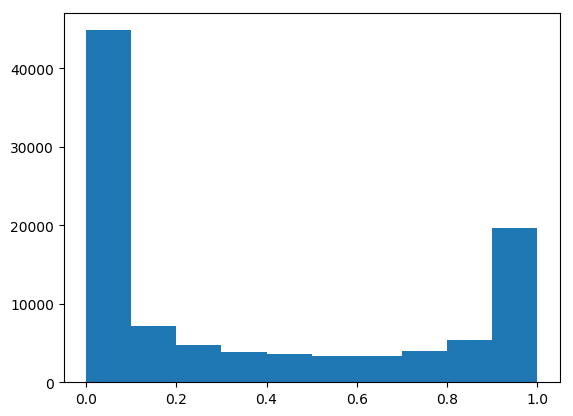

In [76]:
plt = hist(totFshare)
display(plt)

### Calculating the Real Wage Change from Reversion to Autarky 

Following the discussion below equation (20) of TKMD (2018), the change in the real wage from reversion to autarky is
$$
\Delta \left( \frac{w}{P} \right) = \left(\sum_j s_{jH} \left(1 - s_{Fj}^{Tot} \right)^{\frac{1-\sigma}{1-\rho}} \right)^{\frac{1}{\sigma-1}}.
$$
In my simulation the corresponding percentage change is 56%, which is not too far in magnitude from the estimate of 44% in section 3.3 of TKMD (2018).

In [87]:
one = ones(num,1)
sH = (p_H .^ (1-sigma)) / (P^(1-sigma))
dRealWage = (sum(sH[:,1] .* ((one[:,1]-totFshare[:,1]).^((1-sigma)/(1-rho))))^(1/(sigma-1)))*100 / w
dRealWage = ceil(dRealWage)
println("The percentage real wage change from reversion to autarky is roughly ", dRealWage, "%")

The percentage real wage change from reversion to autarky is roughly 56.0%


### The Effects of a 10% Foreign Price Increase

In [99]:
# 10% increase in foreign price
p_F = 1.1 * p_F
P_F = (sum(p_F.^(1-sigma)))^(1/(sigma-1));
E_F = ((w * mu) / P_F)^(sigma-1)

319.7002234153195